In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
from reader import Reader
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import cv2
import os
from skimage import exposure, transform
import pickle
import tensorflow as tf

In [2]:
file = open(r"D:/picklefiles/data_1.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"D:/picklefiles/labels_1.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [3]:
input_shape = data[0].shape
print(input_shape)
print(labels[0])
#cv2.imshow("test", data[0])
#cv2.waitKey()
#cv2.destroyAllWindows()

(64, 96, 3)
{(34.78260869565217, 3.130434782608696, 61.21739130434783, 29.217391304347824): 9}


In [4]:
targets = []
for k in labels:
    e = next(iter(k))
    x1, y1, x2, y2 = e
    h, w = input_shape[:2]
    x1 = x1/w
    y1 = y1/h
    x2 = x2/w
    y2 = y2/h
    targets.append((x1, y1, x2, y2))

In [5]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, test_size=0.25, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

In [6]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Flatten(name='bl_8')(base_layers)

In [7]:
#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [8]:
model = tf.keras.Model(input_layer, outputs=locator_branch)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 96, 3)]       0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 64, 96, 16)        448       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 32, 48, 16)        0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 32, 48, 32)        4640      
_________________________________________________________________
bl_5 (MaxPooling2D)          (None, 16, 24, 32)        0         
_________________________________________________________________
bl_6 (Conv2D)                (None, 16, 24, 64)        18496     
_________________________________________________________________
bl_7 (MaxPooling2D)          (None, 8, 12, 64)         0     

In [10]:
model.compile(loss=tf.keras.losses.MAE, optimizer='Adam')#, metrics=['accuracy']

In [11]:
history = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=4,
             epochs=8,
             shuffle=True,
             verbose=1)

Epoch 1/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0485 - val_loss: 0.0145
Epoch 2/8
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 3/8
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 4/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 5/8
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 6/8
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 7/8
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0080 - val_loss: 0.0094
Epoch 8/8
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0075 - val_loss: 0.0073


[INFO] saving object detector model...


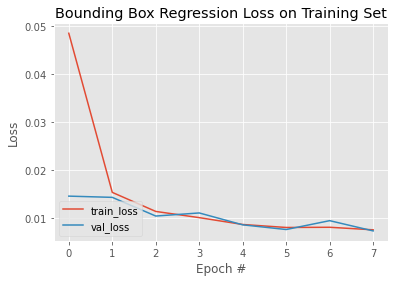

In [13]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(r"models/models_regr_1", save_format="h5")

# plot the model training history
N = 8#NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [6]:
model = load_model(r"models/models_regr_1")
for image, bounding in zip(testImages, testTargets):
    print(image.shape)
    preds = model.predict(np.expand_dims(image, 0))
    print(preds)
    (startX, startY, endX, endY) = preds[0]
    
    h, w = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    
    bounding[0] = int(bounding[0]*w)
    bounding[1] = int(bounding[1]*h)
    bounding[2] = int(bounding[2]*w)
    bounding[3] = int(bounding[3]*h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 1)
    cv2.rectangle(image, (bounding[0], bounding[1]), (bounding[2], bounding[3]), (0, 0, 255), 1)

    # show the output image
    cv2.namedWindow('Output', cv2.WINDOW_NORMAL)
    cv2.imshow("Output", image)
    cv2.waitKey(0)

(64, 96, 3)
[[0.36740366 0.55234325 0.6273632  0.9532429 ]]


C:\Users\holz_so\AppData\Local\Temp\ipykernel_34616\2862633099.py:24: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(image, (bounding[0], bounding[1]), (bounding[2], bounding[3]), (0, 0, 255), 1)


(64, 96, 3)
[[0.02903986 0.04079515 0.3102796  0.46134493]]
(64, 96, 3)
[[0.36649346 0.5531503  0.62683713 0.95297736]]
(64, 96, 3)
[[0.71066236 0.5514107  0.96395385 0.94324887]]
(64, 96, 3)
[[0.70798826 0.05093497 0.96524173 0.4521403 ]]
(64, 96, 3)
[[0.39115277 0.59066594 0.60803276 0.91946095]]
(64, 96, 3)
[[0.03237787 0.04010031 0.3109151  0.4603093 ]]
(64, 96, 3)
[[0.7391206  0.5979802  0.9414704  0.91422737]]
(64, 96, 3)
[[0.37552047 0.05747515 0.6303547  0.4487682 ]]
(64, 96, 3)
[[0.05825248 0.08281568 0.28548652 0.42379433]]
(64, 96, 3)
[[0.36184868 0.54827595 0.6311367  0.95680314]]
(64, 96, 3)
[[0.7127105  0.05605108 0.9633042  0.45010743]]
(64, 96, 3)
[[0.38801268 0.07297105 0.6195087  0.43533343]]
(64, 96, 3)
[[0.7209801  0.07871354 0.9486623  0.43293187]]
(64, 96, 3)
[[0.03575265 0.04719278 0.31417093 0.45873696]]
(64, 96, 3)
[[0.71284854 0.5569616  0.9520728  0.93000805]]
(64, 96, 3)
[[0.39493996 0.08725378 0.611816   0.42765206]]
(64, 96, 3)
[[0.7126368 0.5546223 0.9582

(64, 96, 3)
[[0.72816443 0.57789415 0.9490789  0.92821443]]
(64, 96, 3)
[[0.7256672 0.5777675 0.9489676 0.9282528]]
(64, 96, 3)
[[0.3790831  0.57518077 0.61362773 0.93546367]]
(64, 96, 3)
[[0.73325187 0.09721714 0.93796825 0.4119995 ]]
(64, 96, 3)
[[0.73127127 0.08143654 0.94708216 0.42443523]]
(64, 96, 3)
[[0.3647679 0.5498264 0.6280093 0.9557574]]
(64, 96, 3)
[[0.07253626 0.09522226 0.28263956 0.41389304]]
(64, 96, 3)
[[0.73090523 0.08366945 0.94428563 0.42135435]]
(64, 96, 3)
[[0.3735324  0.05085245 0.63539225 0.45808896]]
(64, 96, 3)
[[0.37232542 0.56429106 0.62255806 0.9440695 ]]
(64, 96, 3)
[[0.36321795 0.0368582  0.6441858  0.46813753]]
(64, 96, 3)
[[0.04080683 0.5516223  0.316521   0.9491857 ]]
(64, 96, 3)
[[0.04730746 0.56811    0.3013298  0.9413197 ]]
(64, 96, 3)
[[0.03702345 0.05473951 0.30510277 0.44984934]]
(64, 96, 3)
[[0.03690028 0.04856357 0.30882233 0.45441118]]
(64, 96, 3)
[[0.3696426  0.5597817  0.62284696 0.9475197 ]]
(64, 96, 3)
[[0.37899178 0.06215143 0.6279358  0

KeyboardInterrupt: 